## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import matplotlib.pyplot as plt

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [17]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "../"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", SEED=42):

    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)

        np.random.seed(SEED)
        shuffler = np.random.permutation(n)
        
        inputs = np.asarray(inputs)
        inputs = inputs[shuffler]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)
        outputs = outputs[shuffler]
        

    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)
        outputs = torch.zeros(n,60, 2).to(device)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

## Create a DataLoader class for training

In [3]:
torch.cuda.current_device()

0

In [4]:
!nvidia-smi

Sat Jun  4 16:44:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.81                 Driver Version: 460.67                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:85:00.0 Off |                  N/A |
| 23%   30C    P8     8W / 250W |    857MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
from torch import nn, optim

class Pred(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(100, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 120)
        )
        
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.reshape(-1, 60, 2)
        return x

In [6]:
def train(pred, opt, train_dataset, train_loader, val_dataset, val_loader):
    device = torch.device('cuda:0')
    pred = pred.to(device)
    train_losses = []
    val_losses = []
    
    early_stop_counter = 0
    early_stop_criteria = 25
    dummy = 1
    for epoch in range(120):

        total_loss = 0
        for i_batch, sample_batch in enumerate(train_loader):
            inp, out = sample_batch
            out = out.to(device)
            inp = inp.to(device)
            preds = pred(inp)
            loss = ((preds - out) ** 2).sum()

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()

        val_loss = 0
        for i_batch, sample_batch in enumerate(val_loader):
            inp, out = sample_batch
            out = out.to(device)
            inp = inp.to(device)
            preds = pred(inp)
            #print(preds)
            loss = ((preds - out) ** 2).sum()
            val_loss += loss.item()

        train_loss = np.sqrt(total_loss / len(train_dataset))
        val_loss = np.sqrt(val_loss / len(val_dataset))

        if dummy == 1:
            dummy -= 1
        else: 
            last_valid = val_losses[-1]
            if last_valid < val_loss:
                early_stop_counter += 1
            else:
                pickle.dump(pred, open('models/mlp_5_layer_' + city + '_large', 'wb'))

            if early_stop_counter == early_stop_criteria:
                break
            
        print('epoch {} train_loss: {} val_loss: {}'.format(epoch, train_loss, val_loss))
        train_losses.append(train_loss)
        val_losses.append(val_loss)


    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses, color ="red", label = "train_loss")
    plt.plot(val_losses, color ="blue", label = "val_loss")
    plt.legend()
    plt.show()

city: austin
epoch 0 train_loss: 17.98005350680174 val_loss: 13.516958649642465
epoch 1 train_loss: 12.559866795426041 val_loss: 12.356017622394553
epoch 2 train_loss: 12.036096628835901 val_loss: 11.99190138356774
epoch 3 train_loss: 11.853536225477662 val_loss: 11.912036489212413
epoch 4 train_loss: 11.832085262479527 val_loss: 11.902649680758268
epoch 5 train_loss: 11.819039350601768 val_loss: 11.890924292118457
epoch 6 train_loss: 11.807370660328557 val_loss: 11.882651678920368
epoch 7 train_loss: 11.7952448319149 val_loss: 11.850427439701496
epoch 8 train_loss: 11.779381534837563 val_loss: 11.816679995637815
epoch 9 train_loss: 11.760050757820293 val_loss: 11.768143476692314
epoch 10 train_loss: 11.74268217747804 val_loss: 11.723692797982546
epoch 11 train_loss: 11.722928205954963 val_loss: 11.669823536297155
epoch 12 train_loss: 11.700671030940013 val_loss: 11.645612226536477
epoch 13 train_loss: 11.672958956980235 val_loss: 11.59891887560907
epoch 14 train_loss: 11.6344850437023

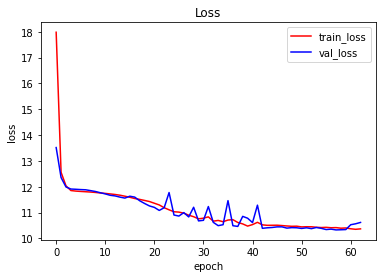

city: miami
epoch 0 train_loss: 19.47774945554715 val_loss: 15.536225079927068
epoch 1 train_loss: 14.410440721027225 val_loss: 11.782315576797018
epoch 2 train_loss: 11.916889814060255 val_loss: 11.627871357732603
epoch 3 train_loss: 12.103210693069451 val_loss: 11.55865145078953
epoch 4 train_loss: 12.109307852684 val_loss: 11.579104813126909
epoch 5 train_loss: 12.083326797949072 val_loss: 11.690888673534685
epoch 6 train_loss: 12.014694339348853 val_loss: 11.933299360302001
epoch 7 train_loss: 11.993904010938287 val_loss: 11.848419095175926
epoch 8 train_loss: 12.055497152067856 val_loss: 11.85473185006572
epoch 9 train_loss: 12.017791152698742 val_loss: 11.765439886612358
epoch 10 train_loss: 11.982612574965573 val_loss: 11.593522327938228
epoch 11 train_loss: 11.944048969362377 val_loss: 11.452401609294284
epoch 12 train_loss: 11.929616765007726 val_loss: 11.39211593163016
epoch 13 train_loss: 11.907842583604667 val_loss: 11.413641546261422
epoch 14 train_loss: 11.890756080382495

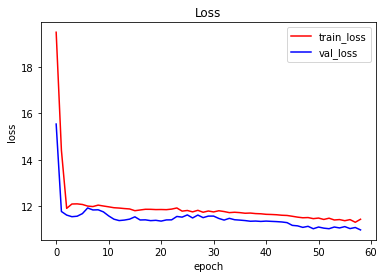

city: pittsburgh
epoch 0 train_loss: 19.118254295828134 val_loss: 17.661065349267066
epoch 1 train_loss: 17.637141818061007 val_loss: 17.650389801777894
epoch 2 train_loss: 15.952380257203579 val_loss: 11.59969694506501
epoch 3 train_loss: 11.549096728043763 val_loss: 11.55982500464354
epoch 4 train_loss: 11.532677995786045 val_loss: 11.544780155207691
epoch 5 train_loss: 11.536635521654974 val_loss: 11.589784005846942
epoch 6 train_loss: 11.538877555552055 val_loss: 11.71496967793072
epoch 7 train_loss: 11.54225819712479 val_loss: 11.892388766611472
epoch 8 train_loss: 11.550914344567156 val_loss: 11.999929529153802
epoch 9 train_loss: 11.564667391472472 val_loss: 12.139038292278004
epoch 10 train_loss: 11.5790286389976 val_loss: 12.270635547277973
epoch 11 train_loss: 11.587125021017124 val_loss: 12.42103059177039
epoch 12 train_loss: 11.590786825035769 val_loss: 12.462943513395627
epoch 13 train_loss: 11.597369772830262 val_loss: 12.479540968301905
epoch 14 train_loss: 11.6020569731

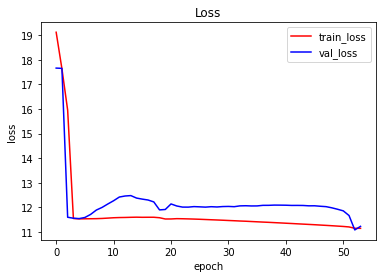

city: dearborn
epoch 0 train_loss: 21.113249519583327 val_loss: 18.344898933988294
epoch 1 train_loss: 16.708369676525713 val_loss: 14.864041572393711
epoch 2 train_loss: 14.50852938092444 val_loss: 13.412846361233413
epoch 3 train_loss: 13.36507005267524 val_loss: 12.763852948101867
epoch 4 train_loss: 12.804359905577034 val_loss: 12.443289851528053
epoch 5 train_loss: 12.691501803929535 val_loss: 12.48636416609775
epoch 6 train_loss: 12.695895105070989 val_loss: 12.387654001757289
epoch 7 train_loss: 12.69461946572093 val_loss: 12.365892874480325
epoch 8 train_loss: 12.695554846236263 val_loss: 12.404374687479448
epoch 9 train_loss: 12.6727072298898 val_loss: 12.361923085724028
epoch 10 train_loss: 12.677221106715551 val_loss: 12.380292193851366
epoch 11 train_loss: 12.673099323357814 val_loss: 12.366153007370126
epoch 12 train_loss: 12.661098911256234 val_loss: 12.349532286700706
epoch 13 train_loss: 12.658344879298529 val_loss: 12.359946870114369
epoch 14 train_loss: 12.64859058998

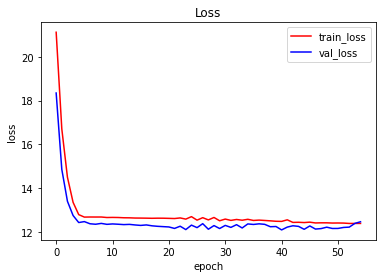

city: washington-dc
epoch 0 train_loss: 19.811190200348303 val_loss: 17.203226308120062
epoch 1 train_loss: 17.19766208300161 val_loss: 17.19974578297096
epoch 2 train_loss: 17.196944786254768 val_loss: 17.19936018713795
epoch 3 train_loss: 17.19648015280372 val_loss: 17.198299221988336
epoch 4 train_loss: 17.135056919227864 val_loss: 16.082212480819972
epoch 5 train_loss: 13.876713200195562 val_loss: 12.149292207572278
epoch 6 train_loss: 11.921874085276915 val_loss: 11.90373812334166
epoch 7 train_loss: 11.772287113194889 val_loss: 11.918392462755605
epoch 8 train_loss: 11.752503753360113 val_loss: 11.885583450686779
epoch 9 train_loss: 11.743872924687135 val_loss: 11.852288944665542
epoch 10 train_loss: 11.738991447524938 val_loss: 11.833482521956814
epoch 11 train_loss: 11.734185838639322 val_loss: 11.840085668739501
epoch 12 train_loss: 11.732833530956592 val_loss: 11.85359893480778
epoch 13 train_loss: 11.733791923892248 val_loss: 11.884923424619728
epoch 14 train_loss: 11.739351

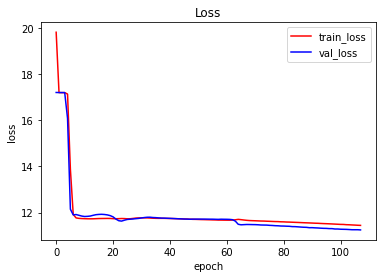

city: palo-alto
epoch 0 train_loss: 19.07576580048918 val_loss: 18.065506321815985
epoch 1 train_loss: 17.741508739868042 val_loss: 16.694187571202445
epoch 2 train_loss: 16.17303741439459 val_loss: 15.468660038230597
epoch 3 train_loss: 14.802695877690576 val_loss: 13.915202133554262
epoch 4 train_loss: 12.98438383954068 val_loss: 12.49247138548423
epoch 5 train_loss: 12.415614199043702 val_loss: 12.30324571765436
epoch 6 train_loss: 12.288464234195072 val_loss: 12.177187332303028
epoch 7 train_loss: 12.293505826044058 val_loss: 12.147187281519408
epoch 8 train_loss: 12.28395902973672 val_loss: 12.134082156957767
epoch 9 train_loss: 12.278797264530626 val_loss: 12.127141653796045
epoch 10 train_loss: 12.266392507168977 val_loss: 12.118319133174554
epoch 11 train_loss: 12.255169468353198 val_loss: 12.109772911545184
epoch 12 train_loss: 12.244967918160533 val_loss: 12.103058939561707
epoch 13 train_loss: 12.23494154353445 val_loss: 12.09494682632585
epoch 14 train_loss: 12.225455745352

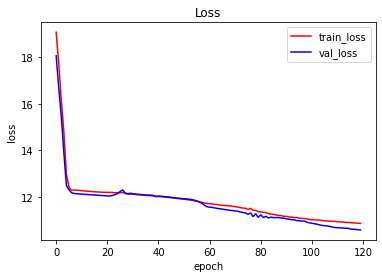

CPU times: user 8min 57s, sys: 8.85 s, total: 9min 5s
Wall time: 9min 6s


In [7]:
%%time
import pickle
#train city models
for city in cities:
    print('city: ' + city)
    batch_sz = 128  # batch size
    train_dataset  = ArgoverseDataset(city = city, split = 'train')
    train_loader = DataLoader(train_dataset,batch_size=batch_sz)
    val_dataset = ArgoverseDataset(city = city, split = 'val')
    val_loader = DataLoader(val_dataset,batch_size=batch_sz)
    
    pred = Pred()
    opt = optim.Adam(pred.parameters(), lr=1e-4)
    train(pred, opt, train_dataset, train_loader, val_dataset, val_loader)
#     pickle.dump(pred, open('models/ta_model_baseline_' + city + '_large', 'wb'))

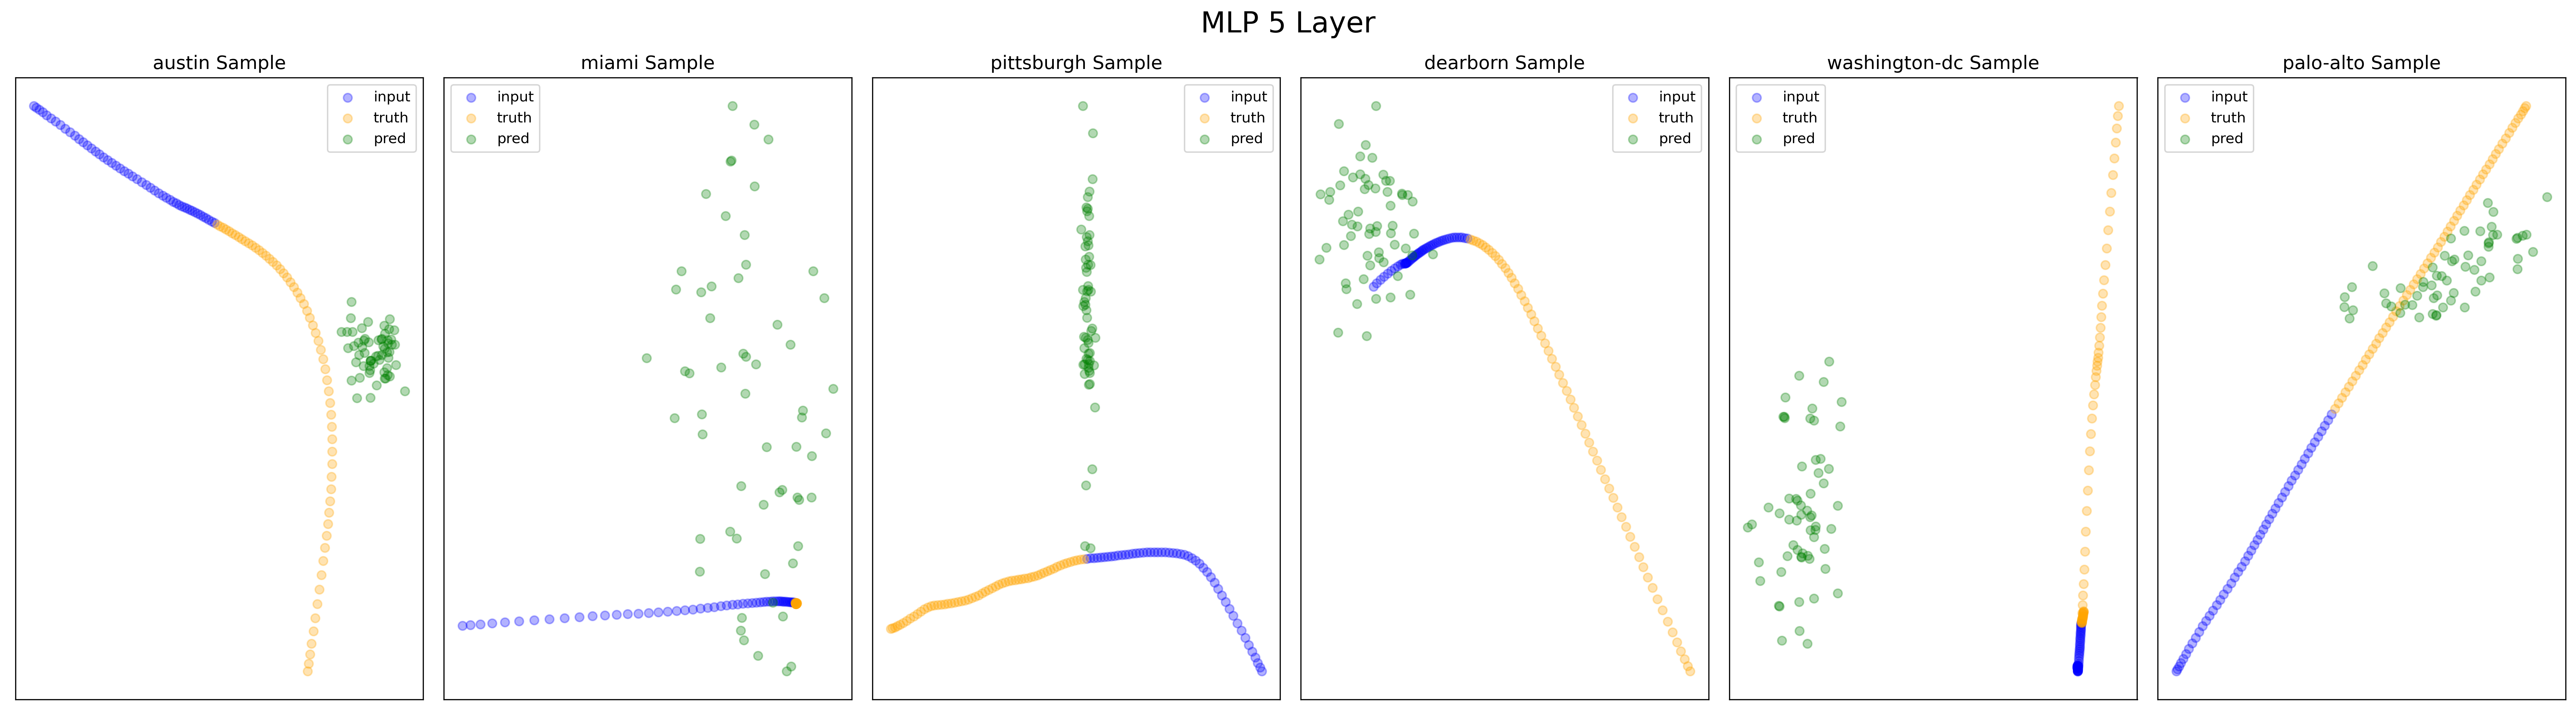

In [25]:
import pandas as pd
import random
cols = np.array(['v' + str(i) for i in range(120)])

fig, axs = plt.subplots(1,6, figsize=(25,7), facecolor='w', edgecolor='k', dpi =300 )
fig.subplots_adjust(hspace = .5, wspace=.1)

axs = axs.ravel()
for city, i in zip(cities,range(0,len(cities))):

    #loading model
    load_pred = pickle.load(open('../models/mlp_5_layer_' + city + '_large', 'rb'))
    
    #get the training dataset/ return inputs, ouputs
    train_dataset= get_city_trajectories(city = city, split = 'train')
    device = torch.device('cuda:0')
    load_pred = load_pred.to(device)
    #input/ truth/ prediction
    inp = train_dataset[0]
    inp_reshaped = inp.reshape(inp.shape[0],100)

    truth = train_dataset[1]
    truth_reshaped =  truth.reshape(truth.shape[0], 120)
    
    preds = load_pred(torch.from_numpy(train_dataset[0]).to(device))
    preds_reshaped = preds.reshape(preds.size()[0], 120)
    preds_numpy = preds_reshaped.cpu().detach().numpy()
    
    
    sample = 27#random.randint(0,len(preds_numpy)) 
    samp_1_truth = truth_reshaped[sample].reshape(60,2)
    samp_1_pred = preds_numpy[sample].reshape(60,2) 
    samp_1_inp = inp_reshaped[sample].reshape(50,2) 

    axs[i].set_title(city,fontsize =13)
    axs[i].xaxis.set_ticks([])
    axs[i].yaxis.set_ticks([])
    axs[i].scatter(samp_1_inp[:,0], samp_1_inp[:,1], color = 'blue', label= 'input', alpha= .3)
    axs[i].scatter(samp_1_truth[:,0], samp_1_truth[:,1], color = 'orange',label= 'truth', alpha= .3)
    axs[i].scatter(samp_1_pred[:,0], samp_1_pred[:,1], color = 'green',label= 'pred', alpha= .3)
    axs[i].legend(loc='best')
fig.suptitle("MLP 5 Layer", fontsize = 20)

plt.tight_layout()
# train_pred = pd.concat(all_preds, ignore_index = True)
# train_pred

In [11]:
cols = np.array(['v' + str(i) for i in range(120)])
all_preds = []
for city in cities:
    #loading model
    load_pred = pickle.load(open('models/mlp_5_layer_' + city + '_large', 'rb'))
    #test dataset
    test_dataset = get_city_trajectories(city = city, split = 'test')
    
    device = torch.device('cuda:0')
    load_pred = load_pred.to(device)
    #prediction
    preds = load_pred(torch.from_numpy(test_dataset[0]).to(device))
    preds_reshaped = preds.reshape(preds.size()[0], 120)
    preds_numpy = preds_reshaped.cpu().detach().numpy()
    ids = np.array([str(i) + '_' + city for i in range(len(preds_numpy))])
    predictions = pd.DataFrame(preds_numpy, columns=cols)
    predictions.insert(0, 'ID', ids)
    all_preds.append(predictions)
    
all_predictions = pd.concat(all_preds, ignore_index = True)

In [12]:
all_predictions

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,-33.643440,-561.061340,-33.209949,-561.149353,-32.783520,-560.002625,-32.287235,-560.862610,-33.072468,...,-30.232080,-564.510071,-30.975397,-564.269592,-29.451416,-564.596191,-29.444979,-563.602966,-30.037779,-563.815796
1,1_austin,-347.869690,-12.992739,-346.102112,-12.267328,-346.992310,-11.727164,-347.314972,-10.757615,-346.540771,...,-345.426239,-13.739157,-344.172272,-14.499689,-345.803711,-14.547304,-346.324890,-11.572450,-347.041534,-12.815673
2,2_austin,51.579216,-248.468750,52.060432,-248.619171,51.901573,-248.836395,51.804642,-248.429565,51.891575,...,52.804802,-248.992172,52.433590,-248.657349,52.741432,-248.770676,52.937428,-248.996796,52.625469,-248.624664
3,3_austin,-119.962273,1793.881836,-118.520149,1793.053711,-119.809494,1796.522949,-119.439026,1793.853149,-118.235535,...,-106.519913,1792.722656,-108.009453,1794.494629,-107.932602,1794.951904,-108.661797,1793.143433,-107.052032,1794.128052
4,4_austin,1232.383667,-656.766357,1232.961060,-656.371216,1231.580811,-655.794312,1233.343384,-655.990540,1232.255371,...,1227.317017,-654.650635,1227.455444,-654.350769,1228.197510,-653.775757,1227.975098,-653.719543,1227.119019,-654.250854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29838,1681_palo-alto,-1397.754395,-480.424591,-1400.359741,-480.294952,-1398.572754,-478.797363,-1402.000488,-481.138336,-1401.494629,...,-1393.116455,-489.569275,-1391.844116,-484.442902,-1392.388306,-486.818634,-1388.170654,-490.014099,-1396.880249,-488.260651
29839,1682_palo-alto,125.337837,2.970722,125.058563,3.499548,125.331894,3.759745,125.423477,3.256328,125.933784,...,126.134613,4.016276,126.537346,3.576427,126.546646,3.676521,126.550819,3.892598,126.441490,3.092578
29840,1683_palo-alto,-1449.878906,2164.913574,-1448.134644,2167.007812,-1447.467651,2164.744629,-1449.600098,2165.956299,-1447.111084,...,-1445.708374,2161.972412,-1447.493896,2166.197754,-1446.993530,2163.069092,-1447.428589,2163.568359,-1446.741211,2163.816162
29841,1684_palo-alto,1067.046387,1399.911255,1071.454102,1397.792603,1070.895996,1401.552124,1070.926270,1403.818970,1070.817505,...,1078.154785,1401.831787,1077.426880,1397.343872,1077.098755,1397.947632,1075.087036,1399.611328,1076.061035,1397.874512


In [ ]:
all_predictions.to_csv('out.csv', index=False)

In [ ]:
pd.read_csv('out.csv')